In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from Helper.silence import silence_all



from Data.data_class import plot_electron_spectrogram
from data_loader import MagnetotailDataset, downweight_variable
from double_transformer import DoubleTransformer
from double_autoencoder import DoubleAutoencoder
from double_transformer_multi import DoubleTransformerMulti
from MAE_transformer_multi import remove_outliers_with_local_interpolation, remove_outliers_with_interpolation

In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA")

2.2.1
12.1
True
NVIDIA GeForce RTX 4060 Laptop GPU


In [ ]:
# TEST DATASET
file_path = Path('..') / "Data" / "testing_data" / "artemis_P1_full_non_split.h5"
abs_file_path = file_path.resolve()

# Create dataset
test_dataset = MagnetotailDataset(abs_file_path)

Setting trainable samples for each section...


100%|██████████| 29/29 [00:00<00:00, 138.47it/s]


Computing plasma beta for each section...


100%|██████████| 29/29 [00:02<00:00, 14.06it/s]


Extracting magnetic field x-component for each section...


100%|██████████| 29/29 [00:00<?, ?it/s]


Computing magnetic field magnitude for each section...


100%|██████████| 29/29 [00:00<?, ?it/s]


In [4]:
# Get the trainable samples from the dataset
test_samples = test_dataset.get_trainable_samples()

In [5]:
test_info = test_dataset.get_session_info()

In [6]:
test_dataset.get_session_info()

[{'id': 'session_0000',
  'start_time': '2011-08-10T12:35:00.000000000',
  'end_time': '2011-08-12T04:55:06.847534592',
  'data_origin': 'Themis_B',
  'num_timestamps': 243,
  'variables': ['electron_avgtemp',
   'electron_density',
   'electron_eflux',
   'electron_velocity_gsm',
   'electron_vthermal',
   'ion_avgtemp',
   'ion_density',
   'ion_eflux',
   'ion_velocity_gsm',
   'ion_vthermal',
   'magnetic_field_gsm',
   'times']},
 {'id': 'session_0001',
  'start_time': '2011-08-12T19:34:10.153708544',
  'end_time': '2011-08-16T09:20:00.000000000',
  'data_origin': 'Themis_B',
  'num_timestamps': 515,
  'variables': ['electron_avgtemp',
   'electron_density',
   'electron_eflux',
   'electron_velocity_gsm',
   'electron_vthermal',
   'ion_avgtemp',
   'ion_density',
   'ion_eflux',
   'ion_velocity_gsm',
   'ion_vthermal',
   'magnetic_field_gsm',
   'times']},
 {'id': 'session_0002',
  'start_time': '2011-09-09T04:35:00.000000000',
  'end_time': '2011-09-13T17:22:22.570996992',
  

In [7]:
sections_to_test = []
for i in range(23, 28):
    section = test_info[i]['id']
    section_id = 'section_' + section[-3:]
    sections_to_test.append(section_id)

samples_test = {k: v for k, v in test_samples.items() if k in sections_to_test}

In [8]:
import pandas as pd

file_path = Path('..') / "Data" / "ART_Xing_times_pos.xlsx"
abs_file_path = file_path.resolve()
# Read the Excel file and extract the first sheet with last 4 columns
df = pd.read_excel(abs_file_path, sheet_name=0)
df = df.iloc[:, -7:-1]  # Keep only the last 4 columns (last one is bugged so it is written with -5 to -1)

crossing_times_ns = pd.to_datetime(df['coupled time']).values.astype('datetime64[ns]')

In [9]:
# TRAINING DATASET

file_path = Path('..') / "Data" / "training_data" / "artemis_P1_v2.h5"
abs_file_path = file_path.resolve()

# Create dataset
dataset = MagnetotailDataset(abs_file_path)

Setting trainable samples for each section...


100%|██████████| 77/77 [00:00<00:00, 280.75it/s]


Computing plasma beta for each section...


100%|██████████| 77/77 [00:02<00:00, 31.52it/s]


Extracting magnetic field x-component for each section...


100%|██████████| 77/77 [00:00<?, ?it/s]


Computing magnetic field magnitude for each section...


100%|██████████| 77/77 [00:00<?, ?it/s]


In [10]:
%matplotlib inline
dataset.set_regions_for_sections(overwrite=False)

In [15]:
# Get the trainable samples from the dataset
train_samples = dataset.get_trainable_samples()

In [16]:
import pandas as pd

file_path = Path('..') / "Data" / "ART_Xing_times_pos.xlsx"
abs_file_path = file_path.resolve()
# Read the Excel file and extract the first sheet with last 4 columns
df = pd.read_excel(abs_file_path, sheet_name=0)
df = df.iloc[:, -7:-1]  # Keep only the last 4 columns (last one is bugged so it is written with -5 to -1)

crossing_times_ns = pd.to_datetime(df['coupled time']).values.astype('datetime64[ns]')

In [38]:
%matplotlib inline
from tqdm import tqdm

# Hyperparameters
timestamps = 4
input_dim = 31
dim_model = [(64, 64)]  
nhead = [(2, 2)]       
num_encoder_layers = [3]
num_decoder_layers = 2
dim_feedforward = [(64, 64)]   # <- keep as high as dim_model
mask_ratio = [0.4]
patches_per_timestamp_spect = 8
n_vectors = 0
epochs = [(60, 60)]

# scalar_options = ['ion_avgtemp', 'ion_density', 'ion_vthermal', 'plasma_beta', 'magnetic_field_gsm_magnitude', 'magnetic_field_gsm_x']
scalar_options = ['ion_avgtemp', 'ion_density', 'ion_vthermal']
n_scalars = len(scalar_options)
data_types = ['ion_eflux'] + scalar_options

models = []

for i in range(1):

    model = DoubleTransformerMulti(
                                        input_dim=input_dim,
                                        timestamps=timestamps,
                                        d_model=dim_model[i],
                                        nhead=nhead[i],
                                        num_encoder_layers=num_encoder_layers[i],
                                        num_decoder_layers=num_decoder_layers,
                                        dim_feedforward=dim_feedforward[i],
                                        mask_ratio=mask_ratio[i],
                                        patches_per_timestamp_spect=patches_per_timestamp_spect,
                                        n_vectors=n_vectors,
                                        n_scalars=n_scalars,
                                        data_types=data_types,
                                        device='cuda' if torch.cuda.is_available() else 'cpu'
                                    )

    train_loss_tail, test_loss_tail, train_loss_sheath, test_loss_sheath = model.fit(
                train_samples,
                epochs=epochs[i],
                batch_size=(96, 128),
                learning_rate=(0.001, 0.001),
                test_fraction=0.1,
                exclude_sections=sessions_to_exclude  
            )
    
    models.append(model)

Padding input_dim from 31 to 32 to make it divisible by 8
Padding input_dim from 31 to 32 to make it divisible by 8
Excluding section section_020 from training and testing data.
Excluding section section_021 from training and testing data.
Excluding section section_022 from training and testing data.
Excluding section section_023 from training and testing data.
Excluding section section_045 from training and testing data.
Excluding section section_046 from training and testing data.
Excluding section section_047 from training and testing data.
Excluding section section_048 from training and testing data.
Excluding section section_073 from training and testing data.
Excluding section section_074 from training and testing data.
Excluding section section_075 from training and testing data.
Excluding section section_076 from training and testing data.
Sample shape for ion_eflux in section_012: torch.Size([4, 31])
Starting training for 60 epochs on device: cuda
Train size: 7507, Test size: 

KeyboardInterrupt: 

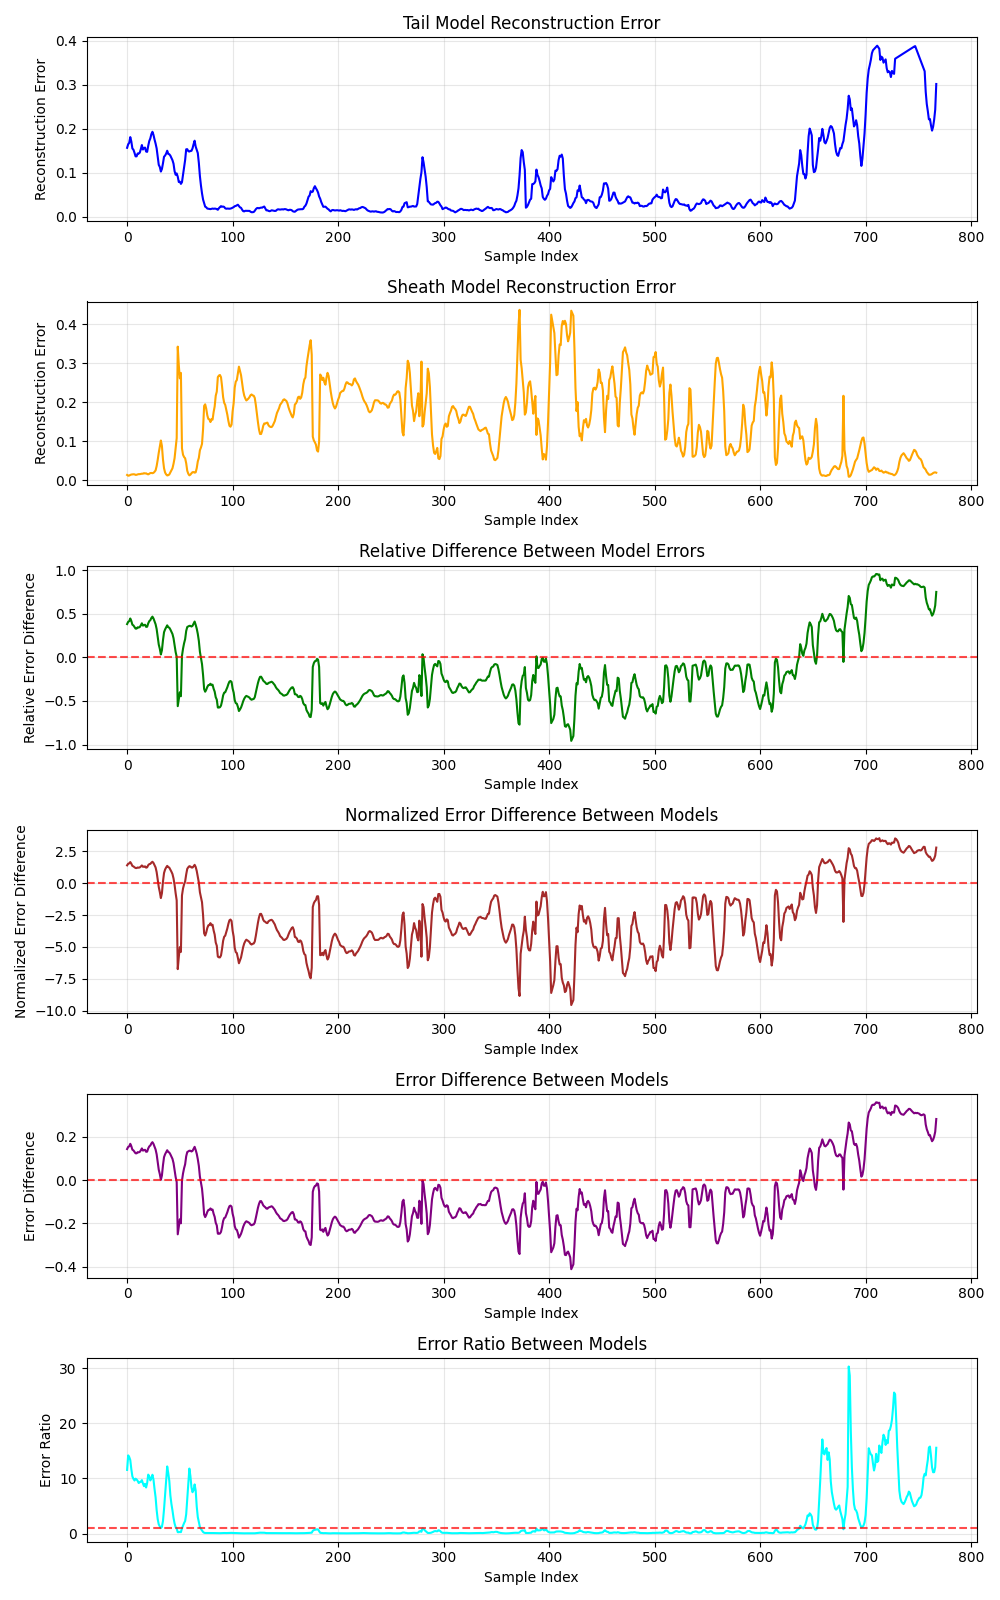

{'zero_crossing_times_relative': None,
 'zero_crossing_times_normalized': None,
 'zero_crossing_times_absolute': None,
 'true_crossings': array(['2011-08-11T00:35:00.000000000', '2011-08-11T01:55:00.000000000',
        '2011-08-11T05:50:00.000000000', '2011-08-11T08:50:00.000000000',
        '2011-08-11T10:40:00.000000000', '2011-08-14T23:20:00.000000000',
        '2011-08-15T00:55:00.000000000', '2011-08-15T01:20:00.000000000',
        '2011-08-15T02:20:00.000000000', '2011-08-15T05:30:00.000000000',
        '2011-08-15T06:00:00.000000000', '2011-08-15T12:35:00.000000000',
        '2011-08-15T12:45:00.000000000', '2011-08-15T13:05:00.000000000',
        '2011-08-15T13:15:00.000000000', '2011-08-15T14:30:00.000000000',
        '2011-08-15T14:45:00.000000000', '2011-08-15T18:05:00.000000000',
        '2011-08-15T21:05:00.000000000', '2011-08-15T21:20:00.000000000',
        '2011-09-09T16:35:00.000000000', '2011-09-09T22:20:00.000000000',
        '2011-09-10T04:40:00.000000000', '2011-09

In [35]:
%matplotlib widget
model.plot_results({'section_023': samples_test['section_023']}, crossing_times=crossing_times_ns, figsize=(10, 16), window_average_errors=1)

In [36]:
results = model.get_results(samples_test, crossing_times=crossing_times_ns, window_average_errors=1)

In [37]:
score = model.get_model_score(results, time_window_minutes=30)
score['dataframe']

,Metric,Relative,Normalized,Absolute
0,True Positive Rate,0.322,0.165,0.314
1,False Positive Rate,0.602,0.500,0.472
2,False Negative Rate,0.678,0.835,0.686
3,True Positives,39,20,38
4,In Range Positives,56,33,53
5,Out Range Predicted Positives,54,19,26
6,False Positives,59,20,34
7,False Negatives,82,101,83
8,Precision,0.398,0.500,0.528
9,F1 Score,0.356,0.248,0.394


In [ ]:
model.save_models('models/double_transformer_multi_v4/tail.pth', 'models/double_transformer_multi_v4/sheath.pth')  

In [18]:
for i, model in enumerate(models):
    model.load_models(f'models/02_09/{i}_tail.pth', f'models/02_09/{i}_sheath.pth')

In [32]:
model.load_models('models/double_transformer_multi_v2/tail.pth', 'models/double_transformer_multi_v2/sheath.pth')

In [158]:
%matplotlib inline
from tqdm import tqdm
# Hyperparameters
timestamps = 4
input_dim = 31
dim_model = 72          
nhead = 2            
num_encoder_layers = 3
num_decoder_layers = 2
dim_feedforward = 64
mask_ratio = 0.4
patches_per_timestamp_spect = 8
n_vectors = 0

# scalar_options = ['ion_avgtemp', 'ion_density', 'ion_vthermal', 'plasma_beta', 'magnetic_field_gsm_magnitude', 'magnetic_field_gsm_x']
scalar_options = [[], ['ion_avgtemp', 'ion_density', 'ion_vthermal']]
scalar_options_str = ['No Scalars', 'With Scalars']

dict_results = {}

n_runs = 5

for i, scalar_option in enumerate(scalar_options):
    
    print(f"Running option: {scalar_options_str[i]}")
    result_per_window = []
    for j in tqdm(range(n_runs)):
        

        # Set random seed for reproducibility
        torch.manual_seed(i)

        data_types = ['ion_eflux'] + scalar_option
        n_scalars = len(scalar_option)
        with silence_all():
            model = DoubleTransformerMulti(
                                    input_dim=input_dim,
                                    timestamps=timestamps,
                                    d_model=dim_model,
                                    nhead=nhead,
                                    num_encoder_layers=num_encoder_layers,
                                    num_decoder_layers=num_decoder_layers,
                                    dim_feedforward=dim_model,
                                    mask_ratio=mask_ratio,
                                    patches_per_timestamp_spect=patches_per_timestamp_spect,
                                    n_vectors=n_vectors,
                                    n_scalars=n_scalars,
                                    data_types=data_types,
                                    device='cuda' if torch.cuda.is_available() else 'cpu'
                                )

            train_loss_tail, test_loss_tail, train_loss_sheath, test_loss_sheath = model.fit(
                        train_samples,
                        epochs=(55, 60),
                        batch_size=(128, 128),
                        learning_rate=(0.0005, 0.001),
                        test_fraction=0.1,
                        exclude_sections=sessions_to_exclude  
                    )
        
        

        for k in range(5):
            results = model.get_results(samples_test, crossing_times=crossing_times_ns, window_average_errors=k)
            score = model.get_model_score(results, time_window_minutes=120)

            if j == 0:
                result_per_window.append(score['detailed_dict'])

            else:
                result_per_window[k]['Relative'] += score['detailed_dict']['Relative']
                result_per_window[k]['Absolute'] += score['detailed_dict']['Absolute']
                result_per_window[k]['Normalized'] += score['detailed_dict']['Normalized']

            if j == (n_runs - 1):
                result_per_window[k]['Relative'] /= n_runs
                result_per_window[k]['Absolute'] /= n_runs
                result_per_window[k]['Normalized'] /= n_runs
    

    dict_results[scalar_options_str[i]] = result_per_window

Running option: No Scalars


100%|██████████| 5/5 [19:17<00:00, 231.57s/it]


Running option: With Scalars


100%|██████████| 5/5 [23:06<00:00, 277.39s/it]


In [160]:
dict_results['With Scalars']

[{'Metric': ['True Positive Rate',
   'False Positive Rate',
   'False Negative Rate',
   'True Positives',
   'In Range Positives',
   'Out Range Predicted Positives',
   'False Positives',
   'False Negatives',
   'Precision',
   'F1 Score',
   'Total True Crossings',
   'Total Predicted Crossings',
   'Time Window (min)',
   'TP Time Accuracy Mean (min)',
   'TP Time Accuracy Std (min)',
   'TP Time Accuracy Mean Signed (min)',
   'TP Time Accuracy Std Signed (min)'],
  'Relative': array([  0.57024793,   0.41525424,   0.42975207,  69.        ,
         106.        ,  33.        ,  49.        ,  52.        ,
           0.58474576,   0.57740586, 121.        , 118.        ,
         120.        ,  23.72378976,  25.44027714,  -8.92295906,
          33.62152143]),
  'Normalized': array([  0.60330579,   0.22340426,   0.39669421,  73.        ,
         113.        ,   7.        ,  21.        ,  48.        ,
           0.77659574,   0.67906977, 121.        ,  94.        ,
         120.     

In [148]:
result_per_window[0]['Relative']


[0.5619834710743802,
 0.2916666666666667,
 0.4380165289256198,
 68,
 110,
 15,
 28,
 53,
 0.7083333333333334,
 0.6267281105990784,
 121,
 96,
 120,
 22.818841657411763,
 26.75840874169081,
 -2.9035487154823536,
 35.04684547616585,
 0.5950413223140496,
 0.49295774647887325,
 0.4049586776859504,
 72,
 104,
 48,
 70,
 49,
 0.5070422535211268,
 0.5475285171102662,
 121,
 142,
 120,
 17.950155601155554,
 20.0846905593547,
 -5.65450351605926,
 26.336846260659257,
 0.5702479338842975,
 0.23333333333333334,
 0.4297520661157025,
 69,
 103,
 13,
 21,
 52,
 0.7666666666666667,
 0.6540284360189573,
 121,
 90,
 120,
 21.852342695594206,
 27.84932411651254,
 2.3492307355033817,
 35.32125210101735,
 0.5371900826446281,
 0.09722222222222222,
 0.4628099173553719,
 65,
 97,
 6,
 7,
 56,
 0.9027777777777778,
 0.6735751295336787,
 121,
 72,
 120,
 31.852918807856152,
 30.677327577476902,
 -5.290051797109488,
 43.90583350603425,
 0.4214876033057851,
 0.34615384615384615,
 0.5785123966942148,
 51,
 88,
 17,

In [92]:
model.transformer_magnetotail.mask[1].reshape(4, -1)

tensor([[0., 0., 0., 0., 1., 1., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 1., 0., 1., 1., 0.],
        [1., 0., 1., 1., 1., 0., 0., 1., 0.]], device='cuda:0')

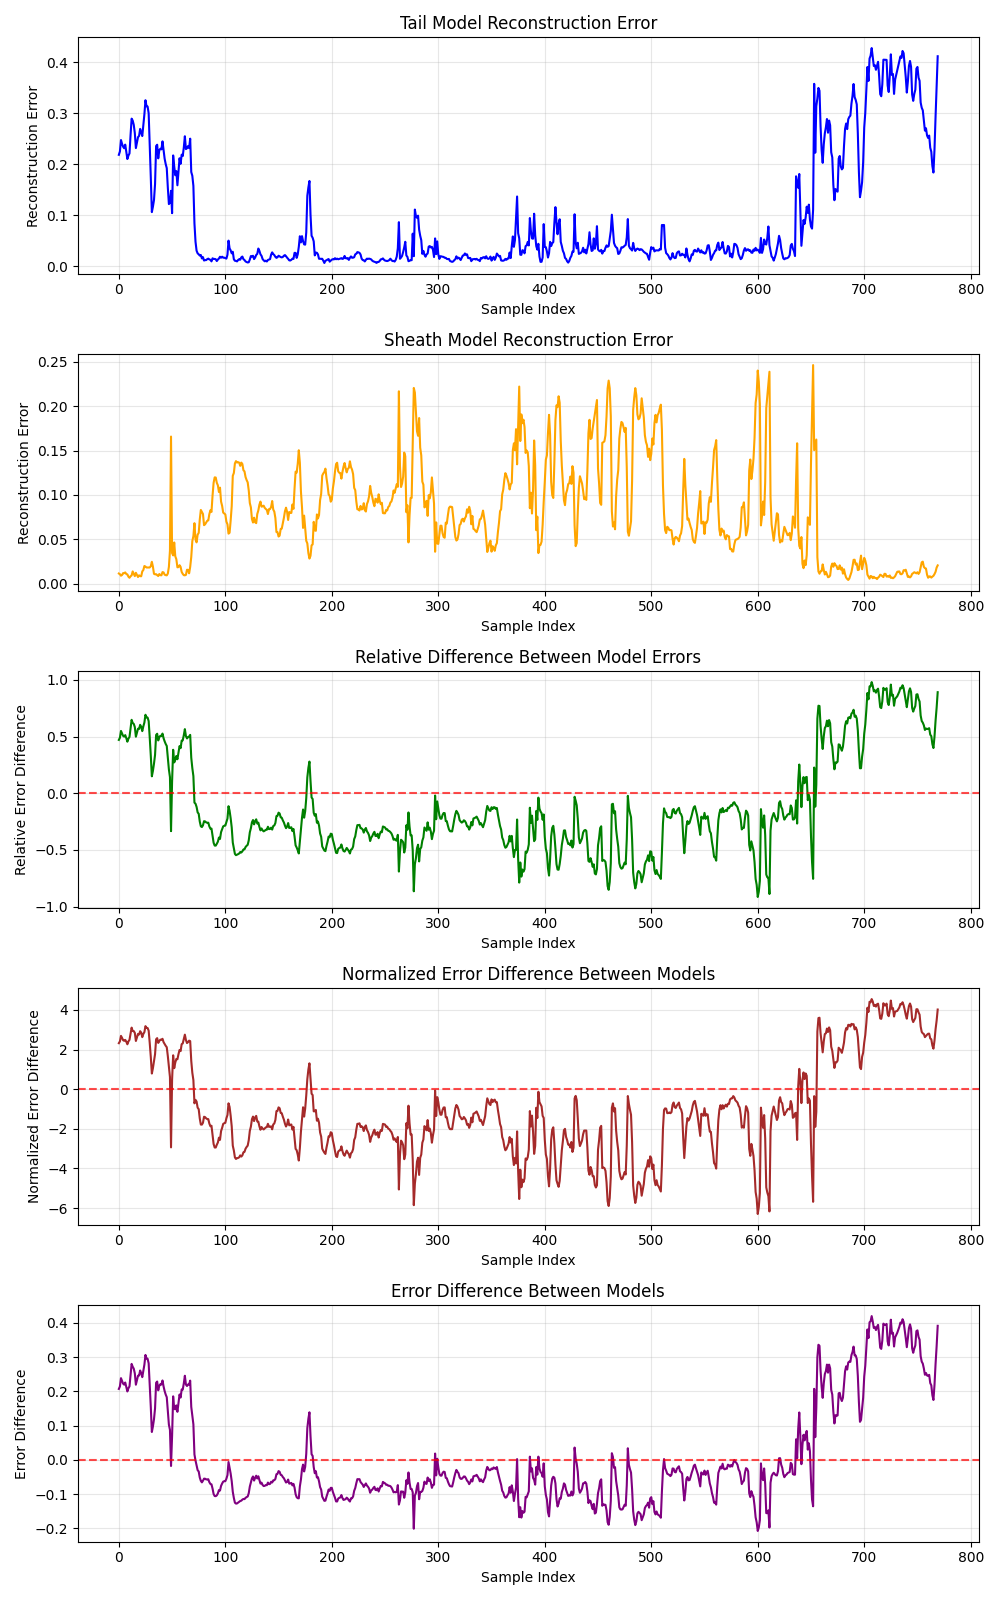

{'zero_crossing_times_relative': None,
 'zero_crossing_times_normalized': None,
 'zero_crossing_times_absolute': None,
 'true_crossings': None}

In [94]:
%matplotlib widget
model.plot_results({'section_023': samples_test['section_023']}, plot=True, figsize=(10, 16), window_average_errors=1)

In [ ]:
# # model.load_models('models/31_08/transformer_magnetotail.pth', 'models/31_08/transformer_magnetosheath.pth')
# model.save_models('models/31_08/transformer_magnetotail_1.pth', 'models/31_08/transformer_magnetosheath_1.pth')

In [ ]:
results = model.get_results(samples_test, crossing_times=crossing_times_ns, window_average_errors=i)

In [133]:
score = model.get_model_score(results, time_window_minutes=120)
score['dataframe']

,Metric,Relative,Normalized,Absolute
0,True Positive Rate,0.512,0.603,0.455
1,False Positive Rate,0.114,0.189,0.491
2,False Negative Rate,0.488,0.397,0.545
3,True Positives,62,73,55
4,In Range Positives,96,109,90
5,Out Range Predicted Positives,8,16,47
6,False Positives,8,17,53
7,False Negatives,59,48,66
8,Precision,0.886,0.811,0.509
9,F1 Score,0.649,0.692,0.480


In [135]:
score['detailed_dict']['Normalized']

[0.6033057851239669,
 0.18888888888888888,
 0.39669421487603307,
 73,
 109,
 16,
 17,
 48,
 0.8111111111111111,
 0.6919431279620853,
 121,
 90,
 120,
 28.47131278143059,
 27.79537266852979,
 -12.355233413873973,
 37.822567345028254]

In [124]:
a = np.array(score['dataframe']['Normalized'])
for i in range(len(a)):
    if isinstance(a[i], str):
        a[i] = np.float64(a[i])
a

array([0.603, 0.189, 0.397, 73, 109, 16, 17, 48, 0.811, 0.692, 121, 90,
       120, 28.47, 27.8, -12.36, 37.82], dtype=object)

In [130]:
a = score['dataframe']

In [132]:
score['dataframe']['Normalized']

0      0.603
1      0.189
2      0.397
3         73
4        109
5         16
6         17
7         48
8      0.811
9      0.692
10       121
11        90
12       120
13     28.47
14     27.80
15    -12.36
16     37.82
Name: Normalized, dtype: object

In [126]:
b = score['dataframe']

In [129]:
c = a + b
c

,Metric,Relative,Normalized,Absolute
0,True Positive RateTrue Positive Rate,0.5120.512,0.6030.603,0.4550.455
1,False Positive RateFalse Positive Rate,0.1140.114,0.1890.189,0.4910.491
2,False Negative RateFalse Negative Rate,0.4880.488,0.3970.397,0.5450.545
3,True PositivesTrue Positives,124,146,110
4,In Range PositivesIn Range Positives,192,218,180
5,Out Range Predicted PositivesOut Range Predict...,16,32,94
6,False PositivesFalse Positives,16,34,106
7,False NegativesFalse Negatives,118,96,132
8,PrecisionPrecision,0.8860.886,0.8110.811,0.5090.509
9,F1 ScoreF1 Score,0.6490.649,0.6920.692,0.4800.480


In [ ]:
%matplotlib inline

# Smaller test script for the following script
import os
import matplotlib.pyplot as plt

# Fixed (leftmost) hyperparameters
timestamps = 3
input_dim = 31
dim_model = [128]          # leftmost of [128, 256]
nhead_options = [4]             # leftmost of [4, 8]
num_encoder_layers = [4]
num_decoder_layers = 4
dim_feedforward = 128
mask_ratio = 0.25
patches_per_timestamp_spect = 4
n_vectors = 0
n_scalars = 0

# Only vary ion velocity inclusion
ion_velocity_options = [False, True]

# Vector options
vector_options   = [None]
# vector_options = ['ion_velocity_gsm']
# vector_options = [None, 'ion_velocity_gsm', 'magnetic_field_gsm', ['magnetic_field_gsm', 'ion_velocity_gsm']]

# Scalar options
scalar_options = ['ion_avgtemp', 'ion_density', 'ion_vthermal', 'plasma_beta', 'magnetic_field_gsm_magnitude', 'magnetic_field_gsm_x']

model_configs = []
for vector in vector_options:
    for scalar in scalar_options:
        for nhead in nhead_options:
            for n_layers in num_encoder_layers:
                for d_model in dim_model:
                    
                    data_types = ['ion_eflux']  # leftmost choices exclude magnetic field & temps/densities
                    
                    if vector is not None:
                        if isinstance(vector, list):
                            data_types.extend(vector)
                            n_vectors = len(vector)
                        else:
                            data_types.append(vector)
                            n_vectors = 1

                    if scalar is not None:
                        if isinstance(scalar, list):
                            data_types.extend(scalar)
                            n_scalars = len(scalar)
                        else:
                            data_types.append(scalar)
                            n_scalars = 1

                    model = DoubleTransformerMulti(
                        input_dim=input_dim,
                        timestamps=timestamps,
                        d_model=d_model,
                        nhead=nhead,
                        num_encoder_layers=n_layers,
                        num_decoder_layers=num_decoder_layers,
                        dim_feedforward=d_model,
                        mask_ratio=mask_ratio,
                        patches_per_timestamp_spect=patches_per_timestamp_spect,
                        n_vectors=n_vectors,
                        n_scalars=n_scalars,
                        data_types=data_types,
                        device='cuda' if torch.cuda.is_available() else 'cpu'
                    )
                    model_configs.append(model)

# Train
results = []
for i, model in enumerate(model_configs):
    print(f"Training model {i+1}/{len(model_configs)}")
    print(f"Configuration: d_model={model.d_model}, nhead={model.nhead}, data_types={model.data_types}")



    # Train with different epoch configurations and store intermediate results
    epoch_configs_1_feature = [(20, 20)]
    epoch_configs_2_features = [(15, 25)]
    
    epoch_configs = epoch_configs_2_features if model.n_vectors > 0 else epoch_configs_1_feature

    for epoch_idx, epochs in enumerate(epoch_configs):
        print(f"  Training with epochs {epochs}")
        
        # Create a fresh copy of the model for each epoch configuration
        fresh_model = DoubleTransformerMulti(
            input_dim=input_dim,
            timestamps=timestamps,
            d_model=d_model,
            nhead=model.nhead,
            num_encoder_layers=model.num_encoder_layers,
            num_decoder_layers=model.num_decoder_layers,
            dim_feedforward=model.dim_feedforward,
            mask_ratio=mask_ratio,
            patches_per_timestamp_spect=patches_per_timestamp_spect,
            n_vectors=model.n_vectors,
            n_scalars=model.n_scalars,
            data_types=model.data_types,
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )
        
        train_loss_tail, test_loss_tail, train_loss_sheath, test_loss_sheath = fresh_model.fit(
            train_samples,
            epochs=epochs,
            batch_size=96,
            learning_rate=0.001,
            test_fraction=0.1,
            exclude_sections=['']  # Use a fraction of the data for testing
        )

        results.append({
            'model': fresh_model,
            'epochs': epochs,
            'epoch_config_idx': epoch_idx,
            'train_loss_tail': train_loss_tail,
            'test_loss_tail': test_loss_tail,
            'train_loss_sheath': train_loss_sheath,
            'test_loss_sheath': test_loss_sheath,
            'config': {
                'd_model': fresh_model.d_model,
                'nhead': fresh_model.nhead,
                'data_types': fresh_model.data_types
            }
        })
        print(f"  Epochs {epochs} completed")
    print(f"Model {i+1} training completed with all epoch configurations\n")

print(f"All {len(model_configs)} models trained successfully!")



Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Training model 1/1
Configuration: d_model=128, nhead=4, data_types=['ion_eflux', 'ion_avgtemp', 'ion_density', 'electron_density', 'ion_vthermal']
  Training with epochs (20, 20)
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Starting training for 20 epochs on device: cuda
Train size: 9257, Test size: 1633, Batch size: 96
Epoch [1/20] - Train Loss: 0.737394, Test Loss: 0.375901
Epoch [2/20] - Train Loss: 0.295201, Test Loss: 0.226968
Epoch [3/20] - Train Loss: 0.226031, Test Loss: nan
Epoch [4/20] - Train Loss: 0.179780, Test Loss: 0.151076
Epoch [5/20] - Train Loss: 0.163019, Test Loss: 0.136399
Epoch [6/20] - Train Loss: 0.153855, Test Loss: 0.137894
Epoch [7/20] - Train Loss: 0.141458, Test Loss: 0.131157
Epoch [8/20] - Train Loss: 0.142339, Test Loss: 0.151253
Epoch [9/20] - Train Loss: 0.136536, Tes

In [140]:
import matplotlib

# Plot & save
matplotlib.use('Agg')  # Use non-interactive backend for saving plots

# Get current date and time for unique filenames
from datetime import datetime
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
current_date = datetime.now().strftime("%Y-%m-%d")

directory_name = f'model_results_plots_{current_date}_test10_4_scalars'

os.makedirs(directory_name, exist_ok=True)
for i, result in enumerate(results):
    model = result['model']
    config = result['config']
    filename = f"model_{i+1}_d{config['d_model']}_h{config['nhead']}_features_{len(config['data_types'])}_epochs_[{result['epochs'][0]},{result['epochs'][1]}]_{current_time}.png"
    print(f"Plotting results for model {i+1}/{len(results)}")

    fig, axes = model.plot_results(testing_samples, figsize=(8, 14))
    fig.suptitle(
        f"Model {i+1}: d_model={config['d_model']}, nhead={config['nhead']}\nFeatures: {config['data_types']}",
        fontsize=10, y=0.98
    )
    
    # Save before closing
    plt.savefig(os.path.join(directory_name, filename), dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close the specific figure, not all figures

print(f"All plots saved to '{directory_name}' folder!")

# Reset to widget backend if needed for interactive plots
matplotlib.use('widget')

Plotting results for model 1/1
All plots saved to 'model_results_plots_2025-08-19_test10_4_scalars' folder!


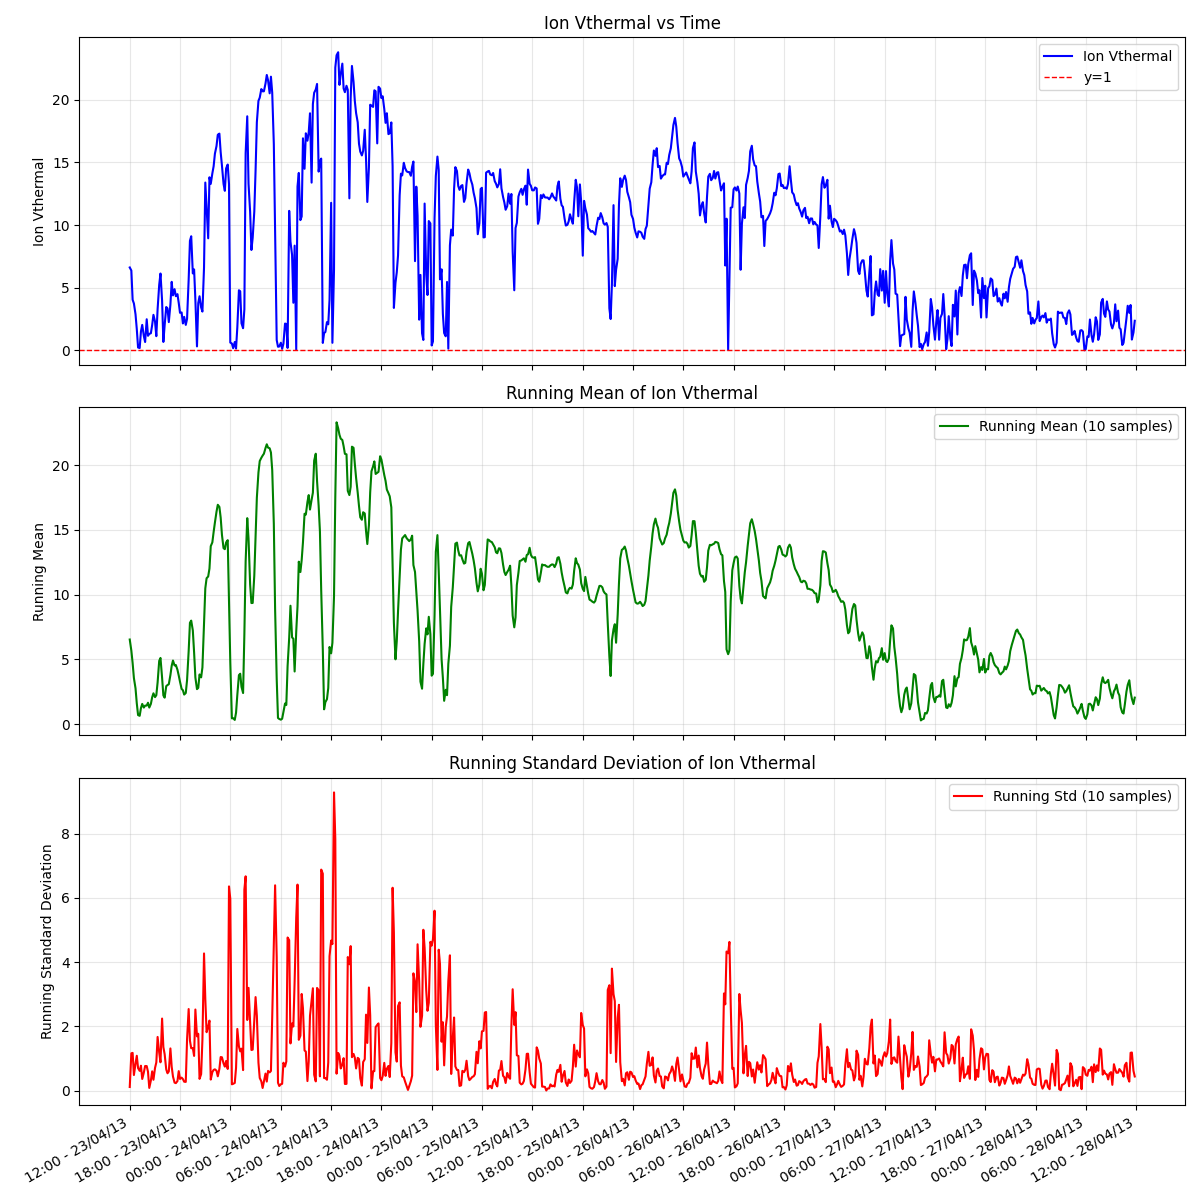

In [253]:

# Get the electron density data
# electron_density = torch.sqrt(torch.sum(testing_samples['section_000']['magnetic_field_gsm']**2, dim=-1)) # Example: using the first component of magnetic field

electron_density = testing_samples['section_000']['magnetic_field_gsm_x'] # Example: using ion_vthermal

# Get section times
# section_times = testing_dataset.get_section_times()['section_000']


# Floor the electron density to avoid negative values
# electron_density, _, _ = downweight_variable(electron_density, p=41, win=3, smoother_win=15, mode='exp', wmin=0.05)

log_data = False # Set to True if you want to log the data

# Remove outliers of electron density
if log_data:
    electron_density = torch.log(electron_density)

# Calculate running mean and standard deviation with window size 10
window_size = 3
electron_density_np = electron_density.cpu().numpy()

# Pad the data for edge handling
padded_data = np.pad(electron_density_np, window_size//2, mode='edge')

# Calculate running statistics
running_mean = []
running_std = []

for i in range(len(electron_density_np)):
    window_data = padded_data[i:i+window_size]
    running_mean.append(np.mean(window_data))
    running_std.append(np.std(window_data))

running_mean = np.array(running_mean)
running_std = np.array(running_std)

# Create time axis
if section_times is not None:
    time_axis = section_times
elif 'times' in testing_samples['section_000']:
    times = testing_samples['section_000']['times']
    time_axis = range(len(times))
else:
    time_axis = range(len(electron_density))

# Create the plot with subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
# Plot 1: Original electron density
ax1.plot(time_axis, electron_density_np, linewidth=1.5, color='blue', label='Ion Vthermal')
ax1.axhline(y=np.log(1), color='red', linestyle='--', linewidth=1, label='y=1')
ax1.set_ylabel('Ion Vthermal')
ax1.set_title('Ion Vthermal vs Time')
ax1.grid(True, alpha=0.3)
if section_times is not None:
    ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M %d-%m-%Y'))
    ax1.xaxis.set_major_locator(matplotlib.dates.HourLocator(interval=6))
    fig.autofmt_xdate()
ax1.legend()

# Plot 2: Running mean
ax2.plot(time_axis, running_mean, linewidth=1.5, color='green', label='Running Mean (10 samples)')
ax2.set_ylabel('Running Mean')
ax2.set_title('Running Mean of Ion Vthermal')
ax2.grid(True, alpha=0.3)
if section_times is not None:
    ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M %d-%m-%Y'))
    ax2.xaxis.set_major_locator(matplotlib.dates.HourLocator(interval=6))
    fig.autofmt_xdate()

ax2.legend()

# Plot 3: Running standard deviation
ax3.plot(time_axis, running_std, linewidth=1.5, color='red', label='Running Std (10 samples)')
ax3.set_ylabel('Running Standard Deviation')
ax3.set_title('Running Standard Deviation of Ion Vthermal')
ax3.grid(True, alpha=0.3)
if section_times is not None:
    ax3.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M - %d/%m/%y'))
    ax3.xaxis.set_major_locator(matplotlib.dates.HourLocator(interval=6))
    fig.autofmt_xdate(bottom=0.5)

ax3.legend()


plt.tight_layout()
plt.show()

In [118]:
np.where(electron_density_np > 130)

(array([109], dtype=int64),)

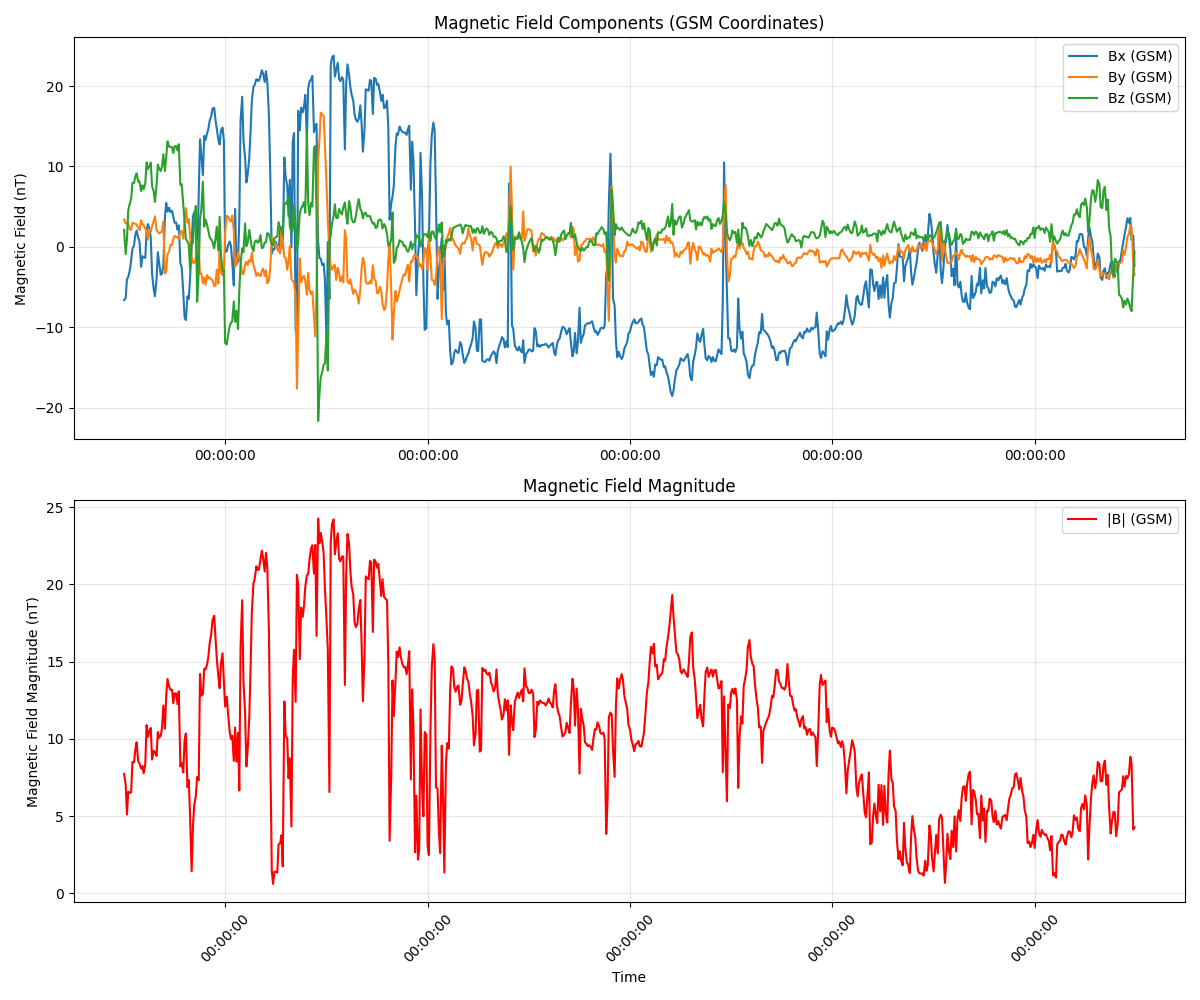

In [ ]:
from datetime import datetime, timezone
from matplotlib import dates as mdates
import numpy as np
Figure 22

# Get the magnetic field data
mag_field = testing_samples['section_000']['magnetic_field_gsm']



# Get the times and convert to datetime
time_ns = testing_samples['section_000']['times'].cpu().numpy().astype('int64')
time_s = time_ns / 1e9
times_datetime = [datetime.fromtimestamp(ts, timezone.utc) for ts in time_s]

# Calculate magnetic field magnitude
mag_field_magnitude = torch.sqrt(mag_field[:, 0]**2 + mag_field[:, 1]**2 + mag_field[:, 2]**2)
# Calculate the standard deviation of the magnetic field magnitude
mag_field_magnitude_std = torch.std(mag_field_magnitude)

# Remove all values above 3 standard deviations from the mean and replace with interpolated of surrounding values
mean_magnitude = torch.mean(mag_field_magnitude)
mag_field_magnitude[mag_field_magnitude > mean_magnitude + 3 * mag_field_magnitude_std] = np.nan
# Use torch.isnan to find NaN values and interpolate them
nan_mask = torch.isnan(mag_field_magnitude)
if nan_mask.any():
    # Get indices of valid (non-NaN) values
    valid_indices = torch.where(~nan_mask)[0]
    nan_indices = torch.where(nan_mask)[0]
    
    if len(valid_indices) > 1:
        # Interpolate NaN values using linear interpolation
        mag_field_magnitude[nan_indices] = torch.tensor(np.interp(
            nan_indices.cpu().numpy(),
            valid_indices.cpu().numpy(),
            mag_field_magnitude[valid_indices].cpu().numpy()
        ), dtype=mag_field_magnitude.dtype).to(mag_field_magnitude.device)




# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# First plot - Components
ax1.plot(times_datetime, mag_field[:, 0].cpu().numpy(), label='Bx (GSM)', linewidth=1.5)
ax1.plot(times_datetime, mag_field[:, 1].cpu().numpy(), label='By (GSM)', linewidth=1.5)
ax1.plot(times_datetime, mag_field[:, 2].cpu().numpy(), label='Bz (GSM)', linewidth=1.5)

ax1.set_ylabel('Magnetic Field (nT)')
ax1.set_title('Magnetic Field Components (GSM Coordinates)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Second plot - Magnitude
ax2.plot(times_datetime, mag_field_magnitude.cpu().numpy(), label='|B| (GSM)', linewidth=1.5, color='red')

ax2.set_xlabel('Time')
ax2.set_ylabel('Magnetic Field Magnitude (nT)')
ax2.set_title('Magnetic Field Magnitude')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Define how many time steps to use for the input
timestamps = 4

# Initialize the autoencoder
MAE_transformer = DoubleTransformerMulti(
    input_dim= 31, 
    timestamps = timestamps, 
    d_model = 128, 
    nhead = 4, 
    num_encoder_layers = 4,            
    num_decoder_layers = 4, 
    dim_feedforward = 128, 
    mask_ratio = 0.25,
    patches_per_timestamp_spect = 4,
    n_vectors = 2,
    n_scalars = 0,
    data_types=['ion_eflux', 
                'magnetic_field_gsm', 
                'ion_velocity_gsm', 
                # 'electron_velocity_gsm',
                # 'ion_avgtemp', 
                # 'ion_density', 
                # 'electron_avgtemp',
                # 'electron_density',
                # 'electron_vthermal'
                ]
    )

# Create a list to store all model configurations
model_configs = []

# Define parameter combinations
d_models = [128, 256]
nheads = [4, 8]
magnetic_field_options = [False, True]  # False = exclude, True = include
ion_velocity_options = [False, True]
ion_temp_density_options = [False, True]  # False = exclude all three, True = include all three

# Generate all combinations
for d_model in d_models:
    for nhead in nheads:
        for use_magnetic in magnetic_field_options:
            for use_ion_vel in ion_velocity_options:
                for use_ion_temp in ion_temp_density_options:
                    # Build data_types list based on options
                    data_types = ['ion_eflux']
                    
                    if use_magnetic:
                        data_types.append('magnetic_field_gsm')
                    
                    if use_ion_vel:
                        data_types.append('ion_velocity_gsm')
                    
                    if use_ion_temp:
                        data_types.extend(['ion_avgtemp', 'ion_density', 'electron_avgtemp'])
                    
                    # Create model configuration
                    model = DoubleTransformerMulti(
                        input_dim=31, 
                        timestamps=timestamps, 
                        d_model=d_model, 
                        nhead=nhead, 
                        num_encoder_layers=4,            
                        num_decoder_layers=4, 
                        dim_feedforward=128, 
                        mask_ratio=0.25,
                        patches_per_timestamp_spect=4,
                        n_vectors=2,
                        n_scalars=0,
                        data_types=data_types
                    )
                    
                    model_configs.append(model)

# Train all model configurations
results = []

for i, model in enumerate(model_configs):
    print(f"Training model {i+1}/{len(model_configs)}")
    print(f"Configuration: d_model={model.d_model}, nhead={model.nhead}, data_types={model.data_types}")
    
    # Determine epochs based on d_model
    epochs = (20, 35) if model.d_model == 256 else (15, 25)
    
    # Train the model
    train_loss_tail, test_loss_tail, train_loss_sheath, test_loss_sheath = \
        model.fit(train_samples, 
                    epochs=epochs,
                    batch_size=96,
                    learning_rate=0.001)
    
    # Store results
    results.append({
        'model': model,
        'train_loss_tail': train_loss_tail,
        'test_loss_tail': test_loss_tail,
        'train_loss_sheath': train_loss_sheath,
        'test_loss_sheath': test_loss_sheath,
        'config': {
            'd_model': model.d_model,
            'nhead': model.nhead,
            'data_types': model.data_types
        }
    })
    
    print(f"Model {i+1} training completed\n")

print(f"All {len(model_configs)} models trained successfully!")


import matplotlib.pyplot as plt

# Create folder to store figures
os.makedirs('model_results_plots', exist_ok=True)

# Plot results for all models
for i, result in enumerate(results):
    model = result['model']
    config = result['config']
    
    # Generate a descriptive filename
    filename = f"model_{i+1}_d{config['d_model']}_h{config['nhead']}_features_{len(config['data_types'])}.png"
    
    print(f"Plotting results for model {i+1}/{len(results)}")
    
    # Plot results using the model's plot_results method
    fig, axes = model.plot_results(train_samples, figsize=(8, 14))
    
    # Add title with configuration info
    fig.suptitle(f"Model {i+1}: d_model={config['d_model']}, nhead={config['nhead']}\nFeatures: {config['data_types']}", 
                 fontsize=10, y=0.98)
    
    # Save the figure
    plt.savefig(os.path.join('model_results_plots', filename), 
                dpi=300, bbox_inches='tight')
    plt.close()

print(f"All plots saved to 'model_results_plots' folder!")

Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_

AttributeError: 'DoubleTransformerMulti' object has no attribute 'd_model'

In [80]:
train_loss_tail, test_loss_tail,train_loss_sheath, test_loss_sheath = \
    MAE_transformer.fit(train_samples, 
                        epochs=(15, 25),
                        batch_size=96,
                        learning_rate=0.001)

Starting training for 15 epochs...
Train size: 3497, Test size: 616, Batch size: 96
Epoch [1/15] - Train Loss: 1.109479, Test Loss: 0.897021
Epoch [2/15] - Train Loss: 0.830895, Test Loss: 0.816740
Epoch [3/15] - Train Loss: 0.646955, Test Loss: 0.538261
Epoch [4/15] - Train Loss: 0.496919, Test Loss: 0.391422
Epoch [5/15] - Train Loss: 0.378075, Test Loss: 0.304099
Epoch [6/15] - Train Loss: 0.325844, Test Loss: 0.255109
Epoch [7/15] - Train Loss: 0.265216, Test Loss: 0.215549
Epoch [8/15] - Train Loss: 0.231868, Test Loss: 0.209526
Epoch [9/15] - Train Loss: 0.213236, Test Loss: 0.188991
Epoch [10/15] - Train Loss: 0.211016, Test Loss: 0.219906
Epoch [11/15] - Train Loss: 0.196331, Test Loss: 0.200839
Epoch [12/15] - Train Loss: 0.200520, Test Loss: 0.181134
Epoch [13/15] - Train Loss: 0.192379, Test Loss: 0.188365
Epoch [14/15] - Train Loss: 0.192681, Test Loss: 0.173068
Epoch [15/15] - Train Loss: 0.185654, Test Loss: 0.169354
Training completed!
Starting training for 25 epochs...


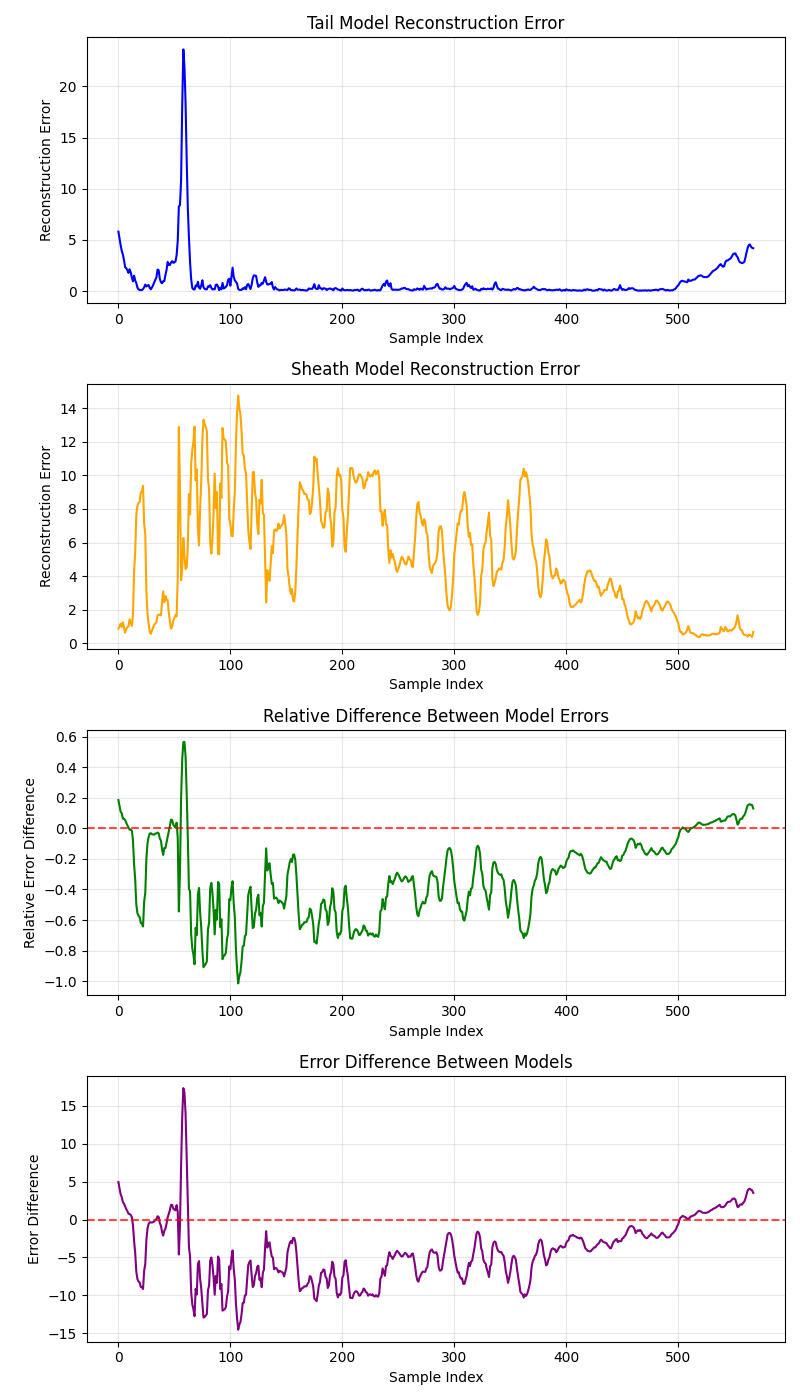

In [81]:
MAE_transformer.plot_results(testing_samples, figsize=(8, 14))

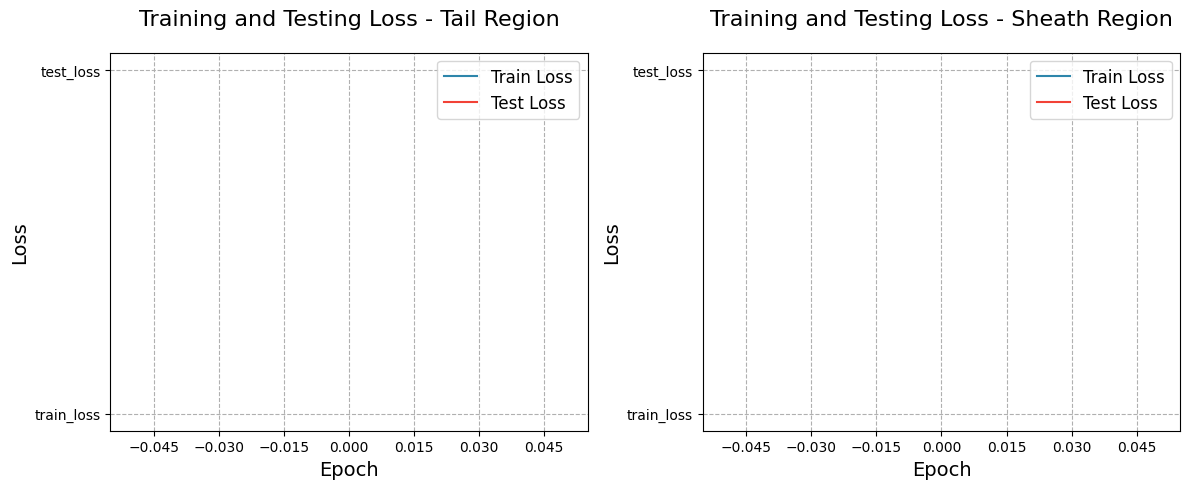

: 

In [ ]:
# Plotting the training and testing loss for the tail and sheath regions

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(train_loss_tail, label='Train Loss', color='#2E86AB')
axs[0].plot(test_loss_tail, label='Test Loss', color='#F24236')
axs[0].set_xlabel('Epoch', fontsize=14)
axs[0].set_ylabel('Loss', fontsize=14)
axs[0].set_title('Training and Testing Loss - Tail Region', fontsize=16, pad=20)
axs[0].legend(fontsize=12)
axs[0].grid(True, alpha=1, linestyle='--')
axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

axs[1].plot(train_loss_sheath, label='Train Loss', color='#2E86AB')
axs[1].plot(test_loss_sheath, label='Test Loss', color='#F24236')
axs[1].set_xlabel('Epoch', fontsize=14)
axs[1].set_ylabel('Loss', fontsize=14)
axs[1].set_title('Training and Testing Loss - Sheath Region', fontsize=16, pad=20)
axs[1].legend(fontsize=12)
axs[1].grid(True, alpha=1, linestyle='--')
axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [ ]:
test_samples = testing_dataset.get_trainable_samples()

In [ ]:
results_tail_model, results_sheath_model, prepared_data = MAE_transformer.predict(test_samples)

In [ ]:
n_sample = 65

test_sample_example = prepared_data[n_sample, :, :].cpu().numpy()
result_tail_model_example = results_tail_model[n_sample, :, :].cpu().numpy()
result_sheath_model_example = results_sheath_model[n_sample, :, :].cpu().numpy()

13-Jul-25 17:35:41: C:\Users\ianma\AppData\Local\Temp\ipykernel_20620\647492426.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks[::-1])

13-Jul-25 17:35:41: C:\Users\ianma\AppData\Local\Temp\ipykernel_20620\647492426.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks[::-1])

13-Jul-25 17:35:41: C:\Users\ianma\AppData\Local\Temp\ipykernel_20620\647492426.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks[::-1])



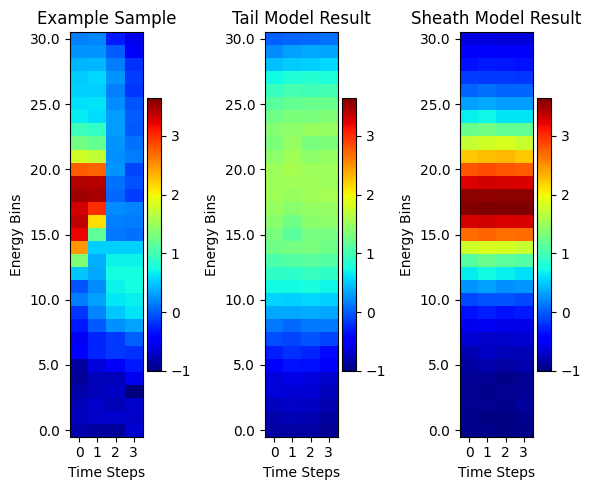

In [ ]:
import matplotlib.ticker as ticker

fig, axs = plt.subplots(1, 3, figsize=(6, 5))

# Find global min and max across all data
vmin = min(test_sample_example.min(), result_tail_model_example.min(), result_sheath_model_example.min())
vmax = max(test_sample_example.max(), result_tail_model_example.max(), result_sheath_model_example.max())

def invert_yaxis_ticks(ax):
    yticks = ax.get_yticks()
    ax.set_yticklabels(yticks[::-1])

# Plot test sample example
im1 = axs[0].imshow(test_sample_example.T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax)
axs[0].set_title('Example Sample')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Energy Bins')
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[0].yaxis.set_major_locator(ticker.MultipleLocator(5))
axs[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%i'))

plt.colorbar(im1, ax=axs[0])
invert_yaxis_ticks(axs[0])

# Plot tail model result
im2 = axs[1].imshow(result_tail_model_example.T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax)
axs[1].set_title('Tail Model Result')
axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('Energy Bins')
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[1].yaxis.set_major_locator(ticker.MultipleLocator(5))
axs[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%i'))

plt.colorbar(im2, ax=axs[1])
invert_yaxis_ticks(axs[1])

# Plot sheath model result
im3 = axs[2].imshow(result_sheath_model_example.T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax)
axs[2].set_title('Sheath Model Result')
axs[2].set_xlabel('Time Steps')
axs[2].set_ylabel('Energy Bins')
axs[2].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[2].yaxis.set_major_locator(ticker.MultipleLocator(5))
axs[2].yaxis.set_major_formatter(ticker.FormatStrFormatter('%i'))

plt.colorbar(im3, ax=axs[2])
invert_yaxis_ticks(axs[2])

plt.tight_layout()
plt.show()


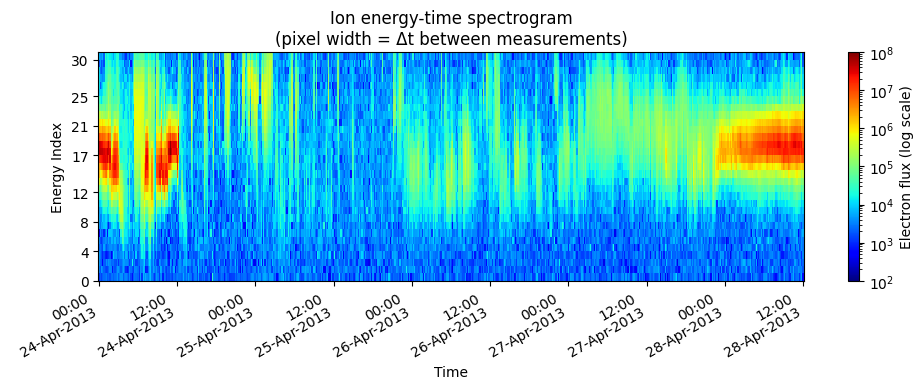

Invalid input. Please enter '1' for magnetotail or '2' for magnetosheath.
Due to invalid input, region was set to None


In [ ]:
testing_dataset.set_regions_for_sections()

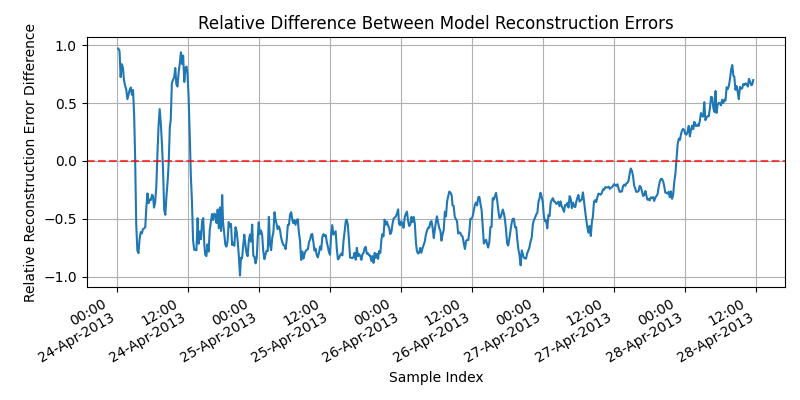

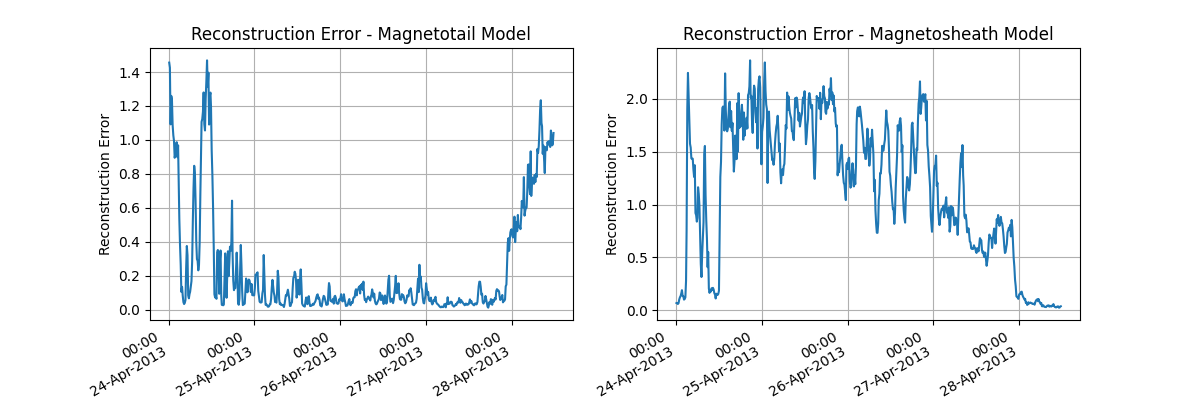

In [ ]:
%matplotlib widget
_ = MAE_transformer.plot_results(test_samples, times=test_samples['section_000']['times'], figsize=(12, 4))

In [ ]:
section_to_region_map = dataset.get_section_to_region_map()

In [ ]:
import datetime

for key in train_samples.keys():

    # Get the time data from train_samples
    sample_times = train_samples[key]['times']

    # Get the first time (nanoseconds since 1970)
    first_time_ns = sample_times[0].item()  # Convert tensor to Python number

    # Convert nanoseconds to seconds
    first_time_s = first_time_ns / 1e9

    # Convert to datetime
    first_time_datetime = datetime.datetime.fromtimestamp(first_time_s)

    print(f"First timestamp: {first_time_datetime}")


First timestamp: 2011-08-14 02:00:52.837745
First timestamp: 2011-08-15 20:39:32.148773
First timestamp: 2011-11-12 00:58:56.508330
First timestamp: 2011-11-12 07:44:23.203094
First timestamp: 2011-11-13 05:36:55.723434
First timestamp: 2011-11-14 00:35:22.883310
First timestamp: 2011-08-16 02:00:13.602259
First timestamp: 2011-08-16 04:35:59.451095
First timestamp: 2011-08-17 11:03:55.735966
First timestamp: 2011-11-09 01:01:04.081035
First timestamp: 2011-09-13 23:09:15.241497
First timestamp: 2011-09-14 16:22:20.209512
First timestamp: 2011-09-15 02:33:56.410089
First timestamp: 2012-02-08 00:59:56.853354
First timestamp: 2012-02-09 15:06:00.928920
First timestamp: 2012-05-02 01:59:58.230397
First timestamp: 2012-05-04 09:05:22.640257
First timestamp: 2012-11-27 01:08:22.327083
First timestamp: 2012-11-30 03:00:46.702051
First timestamp: 2012-11-30 13:05:30.585768
First timestamp: 2011-12-08 05:00:07.292944
First timestamp: 2011-12-10 09:29:45.853968
First timestamp: 2012-01-07 04:2

In [ ]:
test_samples['section_000']['B_ion_eflux'].shape

torch.Size([574, 31])

In [ ]:
import torch.nn.functional as F

# Apply window averaging with padding
# Input shape: [timesteps, energybins]
B_ion_eflux = test_samples['section_000']['B_ion_eflux']

# Add batch and channel dimensions for conv1d: [batch, channels, timesteps]
B_ion_eflux_expanded = B_ion_eflux.transpose(0, 1).unsqueeze(0)  # [1, energybins, timesteps]

# Create averaging kernel of size 5
kernel = torch.ones(1, 1, 3) / 3.0  # [out_channels, in_channels, kernel_size]

# Apply 1D convolution with padding=2 to maintain original length
B_ion_eflux_smoothed = F.conv1d(B_ion_eflux_expanded, kernel.expand(B_ion_eflux_expanded.size(1), 1, -1), 
                                padding=1, groups=B_ion_eflux_expanded.size(1))

# Reshape back to original format: [timesteps, energybins]
B_ion_eflux_smoothed = B_ion_eflux_smoothed.squeeze(0).transpose(0, 1)

print(f"Original shape: {B_ion_eflux.shape}")
print(f"Smoothed shape: {B_ion_eflux_smoothed.shape}")

Original shape: torch.Size([574, 31])
Smoothed shape: torch.Size([574, 31])


In [ ]:
B_ion_eflux_smoothed.shape

torch.Size([574, 31])

In [ ]:
B_ion_eflux_smoothed.max(dim=1).values

tensor([2.8203e+07, 4.2978e+07, 4.4461e+07, 4.0188e+07, 3.4512e+07, 2.9119e+07,
        3.3388e+07, 3.6418e+07, 3.6895e+07, 2.1979e+07, 1.4209e+07, 1.2615e+07,
        2.0085e+07, 2.1175e+07, 1.7127e+07, 1.0682e+07, 5.6941e+06, 2.6014e+06,
        4.9118e+05, 2.9509e+05, 1.6049e+05, 6.2198e+04, 3.5504e+04, 2.4211e+04,
        3.8261e+04, 3.2890e+04, 3.2749e+04, 3.1485e+04, 2.6843e+05, 4.5735e+05,
        6.7076e+05, 6.3769e+05, 6.7766e+05, 6.7025e+05, 6.6301e+05, 6.0933e+05,
        1.3071e+06, 8.9965e+06, 1.7103e+07, 1.8456e+07, 1.2680e+07, 2.4172e+06,
        1.9095e+06, 1.7446e+06, 1.4637e+06, 1.2379e+05, 3.0459e+06, 6.7355e+06,
        1.6580e+07, 2.3192e+07, 2.2780e+07, 1.9986e+07, 1.5960e+07, 1.9241e+07,
        1.9324e+07, 2.2417e+07, 1.9268e+07, 5.4485e+07, 6.6676e+07, 5.8144e+07,
        3.0937e+07, 3.1142e+07, 2.9256e+07, 2.3889e+07, 2.0555e+07, 1.2313e+07,
        1.1420e+07, 5.7221e+04, 5.7844e+04, 4.7111e+04, 2.7307e+04, 1.4632e+04,
        8.9172e+03, 7.8218e+03, 2.1018e+

In [ ]:
avg_test_samples = torch.log(B_ion_eflux_smoothed).mean(dim=1)
std_test_samples = torch.log(B_ion_eflux_smoothed).std(dim=1)

avg_test_samples_norm = (avg_test_samples) / (avg_test_samples.max() - avg_test_samples.min())
std_test_samples_norm = (std_test_samples) / (torch.log(B_ion_eflux_smoothed).max(dim=1).values - torch.log(B_ion_eflux_smoothed).min(dim=1).values)

In [ ]:
opp_avg_test_samples = 1/avg_test_samples_norm 
opp_avg_test_samples_norm = (opp_avg_test_samples) / (opp_avg_test_samples.max() - opp_avg_test_samples.min())

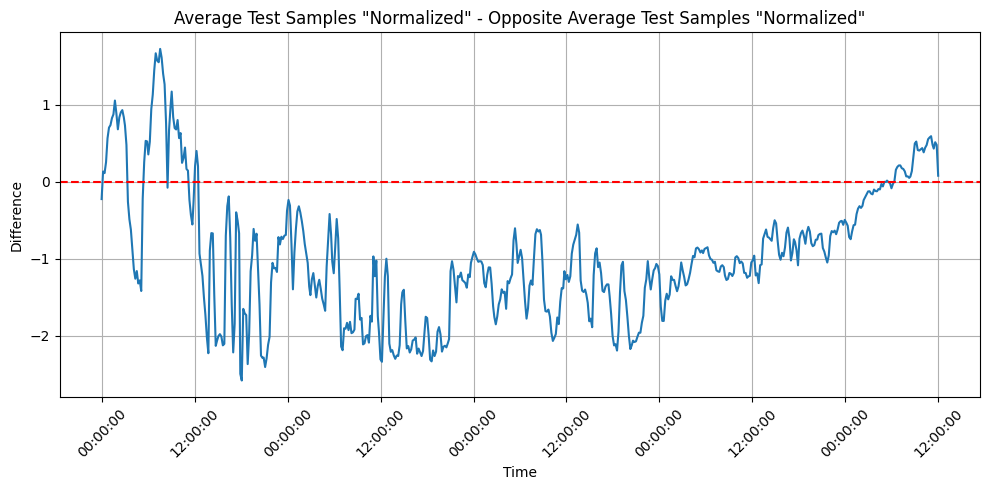

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from matplotlib import dates as mdates
import numpy as np

time_ns = test_samples['section_000']['times'].cpu().numpy().astype('int64')
time_s = time_ns / 1e9
times_datetime = [datetime.fromtimestamp(ts, timezone.utc) for ts in time_s]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(times_datetime,avg_test_samples.numpy() - 2*std_test_samples_norm.numpy() - 10, label='Average Test Samples Normalized')    
ax.set_title('Average Test Samples "Normalized" - Opposite Average Test Samples "Normalized"')
ax.set_xlabel('Time')
ax.set_ylabel("Difference")
ax.axhline(0, color='red', linestyle='--', label='Zero Line')
ax.grid()
ax.xaxis_date()
# Format the x-axis to display times nicely
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
 

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

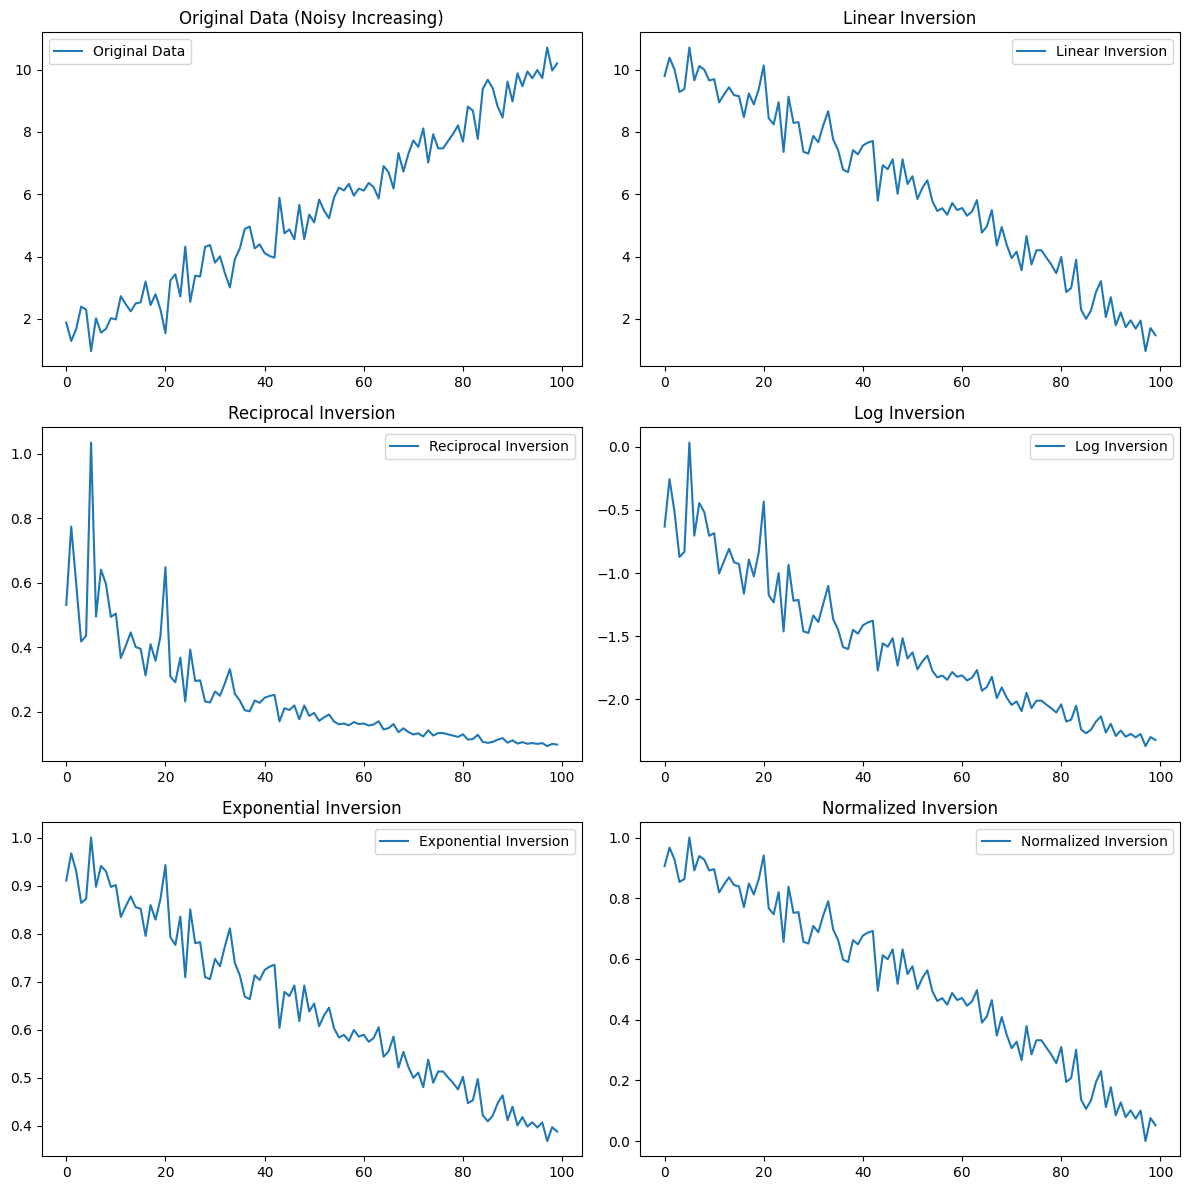

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate noisy increasing data
np.random.seed(0)
x = np.linspace(1, 10, 100) + np.random.normal(0, 0.5, 100)  # avoid zero for log/reciprocal
x = np.clip(x, 1e-3, None)  # Ensure all values are > 0

# Define transformation functions
def linear_inversion(x):
    return np.max(x) + np.min(x) - x

def reciprocal_inversion(x):
    return 1.0 / (x + 1e-5)

def log_inversion(x):
    return -np.log(x + 1e-5)

def exp_inversion(x):
    x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))
    return np.exp(-x_norm)

def normalized_inversion(x):
    return (np.max(x) - x) / (np.max(x) - np.min(x))

# Apply transformations
y_linear = linear_inversion(x)
y_recip = reciprocal_inversion(x)
y_log = log_inversion(x)
y_exp = exp_inversion(x)
y_norm = normalized_inversion(x)

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.ravel()

axs[0].plot(x, label='Original Data')
axs[0].set_title('Original Data (Noisy Increasing)')
axs[0].legend()

axs[1].plot(y_linear, label='Linear Inversion')
axs[1].set_title('Linear Inversion')
axs[1].legend()

axs[2].plot(y_recip, label='Reciprocal Inversion')
axs[2].set_title('Reciprocal Inversion')
axs[2].legend()

axs[3].plot(y_log, label='Log Inversion')
axs[3].set_title('Log Inversion')
axs[3].legend()

axs[4].plot(y_exp, label='Exponential Inversion')
axs[4].set_title('Exponential Inversion')
axs[4].legend()

axs[5].plot(y_norm, label='Normalized Inversion')
axs[5].set_title('Normalized Inversion')
axs[5].legend()

plt.tight_layout()
plt.show()